In [0]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
%matplotlib inline

### Download data

You should go to https://drive.google.com/drive/folders/1dE0TdiRu2hncFPH2_MvXCSmcGcv_ZLGB?usp=sharing
to download the data needed for this practical and the coming practical 4b.

After that, you should upload them into your own google drive so you can see it in colab

In [0]:
# after you upload these data to your own google drive,
# mount them to drive folder so we can use them in colab
from google.colab import drive
!mkdir drive
drive.mount('drive')

In [0]:
#  list all the data in your drive to see if mount successfully.
!ls "drive/My Drive/"

data_DL_practical  DL_practical


# Model
We can load a pre-trained CNN directly through Keras. We choose VGG16, which consists of convolutional and pooling layers first, followed by a few fully connected (dense) layers.

In [0]:
base_model = VGG16(weights='imagenet')
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

We define a model that omits the last layer of the VGG16 net, so we can use it to obtain feature vectors for any given input image.

In [0]:
fc2_model = Model(inputs=base_model.input, outputs=base_model.get_layer("fc2").output)

# Image examples
Let's look at a few example images. We load the image, transform it to a numpy array, and preprocess it for use with VGG16. We store the intermediate steps in dictionaries, for demonstrative purposes.

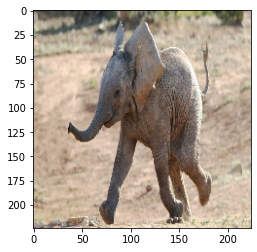

Predictions:
tusker, with probability: 0.37729939818382263
Indian_elephant, with probability: 0.24697455763816833
African_elephant, with probability: 0.2419360727071762
warthog, with probability: 0.039116013795137405
Komodo_dragon, with probability: 0.01597396470606327



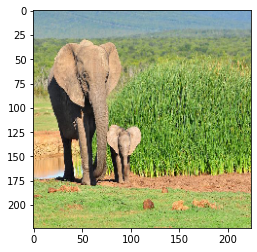

Predictions:
African_elephant, with probability: 0.8334344029426575
tusker, with probability: 0.14022473990917206
Indian_elephant, with probability: 0.022295331582427025
Arabian_camel, with probability: 0.0036693797446787357
bison, with probability: 0.00012928959040436894



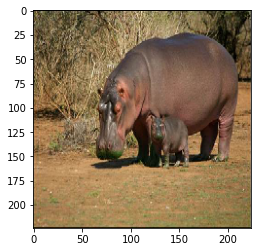

Predictions:
hippopotamus, with probability: 0.9996416568756104
water_buffalo, with probability: 0.0002909673494286835
warthog, with probability: 2.711729939619545e-05
hog, with probability: 2.0471008610911667e-05
Indian_elephant, with probability: 6.381408638844732e-06



In [0]:
def load_img_preprocess(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    array = image.img_to_array(img)
    x = np.expand_dims(array, axis=0)
    x = preprocess_input(x)
    return {"img": img, "array": array, "x": x}

image_fold_path= "drive/My Drive/data_DL_practical/images"

elephant1 = load_img_preprocess(os.path.join(image_fold_path,'elephant1.jpg'))
elephant2 = load_img_preprocess(os.path.join(image_fold_path,'elephant2.jpg'))
hippo1 = load_img_preprocess(os.path.join(image_fold_path,'hippo1.jpg'))

def show_image_predictions(img_obj):
    plt.imshow(img_obj["img"])
    plt.show()
    preds = base_model.predict(img_obj["x"])
    preds_dec = decode_predictions(preds, top=5)[0]
    print("Predictions:")
    for pred in preds_dec:
        print("{}, with probability: {}".format(pred[1],pred[2]))
    print("")

show_image_predictions(elephant1)
show_image_predictions(elephant2)
show_image_predictions(hippo1)

Let's use the fc2_model to obtain feature vectors for our example images, and include them in the dictionaries.

In [0]:
def include_features(img_obj):
    img_obj["fc2"] = fc2_model.predict(img_obj["x"])
    
include_features(elephant1)
include_features(elephant2)
include_features(hippo1)

In [0]:
elephant1["x"].shape[1:]

(224, 224, 3)

We can compare two images (as matrices) or feature vectors by computing the average (squared) distance elementwise. Let's do this for our example images.

In [0]:
# mean L1-distance (mean absolute error)
def mae(a,b):
    return np.absolute(a-b).mean(axis=None)
    
# mean squared L2-distance (mean squared error)
def mse(a,b):
    return ((a-b)**2).mean(axis=None)

print("fc2 feature vectors:")
print(mse(elephant1["fc2"], elephant2["fc2"]))
print(mse(elephant1["fc2"], hippo1["fc2"]))
print(mse(elephant2["fc2"], hippo1["fc2"]))
print("")
print(mae(elephant1["fc2"], elephant2["fc2"]))
print(mae(elephant1["fc2"], hippo1["fc2"]))
print(mae(elephant2["fc2"], hippo1["fc2"]))
print("")
print("original images as 224x224 matrices:")
print(mse(elephant1["array"].flatten(), elephant2["array"].flatten()))
print(mse(elephant1["array"].flatten(), hippo1["array"].flatten()))
print(mse(elephant2["array"].flatten(), hippo1["array"].flatten()))
print("")
print(mae(elephant1["array"].flatten(), elephant2["array"].flatten()))
print(mae(elephant1["array"].flatten(), hippo1["array"].flatten()))
print(mae(elephant2["array"].flatten(), hippo1["array"].flatten()))

fc2 feature vectors:
1.7509234
3.639327
4.3795104

0.64952445
0.88910663
1.029032

original images as 224x224 matrices:
5055.962
6039.2397
4578.4795

56.93345
64.73752
54.445904


Observe that when using the feature vectors, the first two images (both elephants) are considered "more similar" according to these distance measures. Looking at the original images as 224x224 matrices however, the first elephant is more similar to the hippo, according to these distance measures.